In [1]:
import os
import re
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from zipfile import ZipFile
from tensorflow.python.framework import ops
ops.reset_default_graph()

# Start a graph
sess = tf.Session()



In [2]:
# Set RNN parameters
epochs = 50
batch_size = 250
max_sequence_length = 25
rnn_size = 10
embedding_size = 50
min_word_frequency = 10
learning_rate = 0.0005
dropout_keep_prob = tf.placeholder(tf.float32)



In [4]:
# Download or open data
data_dir = 'temp'
data_file = 'text_data.txt'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

if not os.path.isfile(os.path.join(data_dir, data_file)):
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # Format Data
    text_data = file.decode()
    text_data = text_data.encode('ascii', errors='ignore')
    text_data = text_data.decode().split('\n')

    # Save data to text file
    with open(os.path.join(data_dir, data_file), 'w') as file_conn:
        for text in text_data:
            file_conn.write("{}\n".format(text))
else:
    # Open data from text file
    text_data = []
    with open(os.path.join(data_dir, data_file), 'r') as file_conn:
        for row in file_conn:
            text_data.append(row)
    text_data = text_data[:-1]

text_data = [x.split('\t') for x in text_data if len(x) >= 1]
[text_data_target, text_data_train] = [list(x) for x in zip(*text_data)]



In [5]:
# Create a text cleaning function
def clean_text(text_string):
    text_string = re.sub(r'([^\s\w]|_|[0-9])+', '', text_string)
    text_string = " ".join(text_string.split())
    text_string = text_string.lower()
    return text_string


# Clean texts
text_data_train = [clean_text(x) for x in text_data_train]

# Change texts into numeric vectors
vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_sequence_length,
                                                                     min_frequency=min_word_frequency)
text_processed = np.array(list(vocab_processor.fit_transform(text_data_train)))




For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [6]:
# Shuffle and split data
text_processed = np.array(text_processed)
text_data_target = np.array([1 if x == 'ham' else 0 for x in text_data_target])
shuffled_ix = np.random.permutation(np.arange(len(text_data_target)))
x_shuffled = text_processed[shuffled_ix]
y_shuffled = text_data_target[shuffled_ix]

# Split train/test set
ix_cutoff = int(len(y_shuffled)*0.80)
x_train, x_test = x_shuffled[:ix_cutoff], x_shuffled[ix_cutoff:]
y_train, y_test = y_shuffled[:ix_cutoff], y_shuffled[ix_cutoff:]
vocab_size = len(vocab_processor.vocabulary_)
print("Vocabulary Size: {:d}".format(vocab_size))
print("80-20 Train Test split: {:d} -- {:d}".format(len(y_train), len(y_test)))



Vocabulary Size: 933
80-20 Train Test split: 4459 -- 1115


In [7]:
# Create placeholders
x_data = tf.placeholder(tf.int32, [None, max_sequence_length])
y_output = tf.placeholder(tf.int32, [None])

# Create embedding
embedding_mat = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
embedding_output = tf.nn.embedding_lookup(embedding_mat, x_data)

# Define the RNN cell
# tensorflow change >= 1.0, rnn is put into tensorflow.contrib directory. Prior version not test.
if tf.__version__[0] >= '1':
    cell = tf.contrib.rnn.BasicRNNCell(num_units=rnn_size)
else:
    cell = tf.nn.rnn_cell.BasicRNNCell(num_units=rnn_size)

output, state = tf.nn.dynamic_rnn(cell, embedding_output, dtype=tf.float32)
output = tf.nn.dropout(output, dropout_keep_prob)

# Get output of RNN sequence
output = tf.transpose(output, [1, 0, 2])
last = tf.gather(output, int(output.get_shape()[0]) - 1)

weight = tf.Variable(tf.truncated_normal([rnn_size, 2], stddev=0.1))
bias = tf.Variable(tf.constant(0.1, shape=[2]))
logits_out = tf.matmul(last, weight) + bias



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
# Loss function
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_out, labels=y_output)
loss = tf.reduce_mean(losses)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits_out, 1), tf.cast(y_output, tf.int64)), tf.float32))

optimizer = tf.train.RMSPropOptimizer(learning_rate)
train_step = optimizer.minimize(loss)



Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [9]:
init = tf.global_variables_initializer()
sess.run(init)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []



In [10]:
# Start training
for epoch in range(epochs):

    # Shuffle training data
    shuffled_ix = np.random.permutation(np.arange(len(x_train)))
    x_train = x_train[shuffled_ix]
    y_train = y_train[shuffled_ix]
    num_batches = int(len(x_train)/batch_size) + 1
    # TO DO CALCULATE GENERATIONS ExACTLY
    for i in range(num_batches):
        # Select train data
        min_ix = i * batch_size
        max_ix = np.min([len(x_train), ((i+1) * batch_size)])
        x_train_batch = x_train[min_ix:max_ix]
        y_train_batch = y_train[min_ix:max_ix]
        
        # Run train step
        train_dict = {x_data: x_train_batch, y_output: y_train_batch, dropout_keep_prob:0.5}
        sess.run(train_step, feed_dict=train_dict)
        
    # Run loss and accuracy for training
    temp_train_loss, temp_train_acc = sess.run([loss, accuracy], feed_dict=train_dict)
    train_loss.append(temp_train_loss)
    train_accuracy.append(temp_train_acc)
    
    # Run Eval Step
    test_dict = {x_data: x_test, y_output: y_test, dropout_keep_prob:1.0}
    temp_test_loss, temp_test_acc = sess.run([loss, accuracy], feed_dict=test_dict)
    test_loss.append(temp_test_loss)
    test_accuracy.append(temp_test_acc)
    print('Epoch: {}, Test Loss: {:.2}, Test Acc: {:.2}'.format(epoch+1, temp_test_loss, temp_test_acc))



Epoch: 1, Test Loss: 0.76, Test Acc: 0.19
Epoch: 2, Test Loss: 0.72, Test Acc: 0.19
Epoch: 3, Test Loss: 0.67, Test Acc: 0.83
Epoch: 4, Test Loss: 0.61, Test Acc: 0.83
Epoch: 5, Test Loss: 0.55, Test Acc: 0.83
Epoch: 6, Test Loss: 0.5, Test Acc: 0.84
Epoch: 7, Test Loss: 0.47, Test Acc: 0.84
Epoch: 8, Test Loss: 0.45, Test Acc: 0.84
Epoch: 9, Test Loss: 0.43, Test Acc: 0.84
Epoch: 10, Test Loss: 0.42, Test Acc: 0.85
Epoch: 11, Test Loss: 0.41, Test Acc: 0.85
Epoch: 12, Test Loss: 0.41, Test Acc: 0.85
Epoch: 13, Test Loss: 0.41, Test Acc: 0.85
Epoch: 14, Test Loss: 0.41, Test Acc: 0.86
Epoch: 15, Test Loss: 0.4, Test Acc: 0.86
Epoch: 16, Test Loss: 0.4, Test Acc: 0.86
Epoch: 17, Test Loss: 0.4, Test Acc: 0.86
Epoch: 18, Test Loss: 0.4, Test Acc: 0.87
Epoch: 19, Test Loss: 0.39, Test Acc: 0.87
Epoch: 20, Test Loss: 0.39, Test Acc: 0.87
Epoch: 21, Test Loss: 0.39, Test Acc: 0.87
Epoch: 22, Test Loss: 0.39, Test Acc: 0.87
Epoch: 23, Test Loss: 0.38, Test Acc: 0.87
Epoch: 24, Test Loss: 0.3

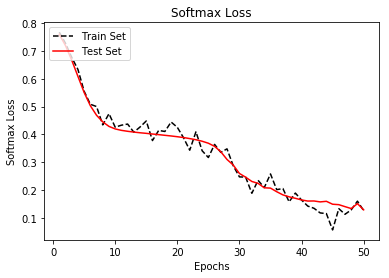

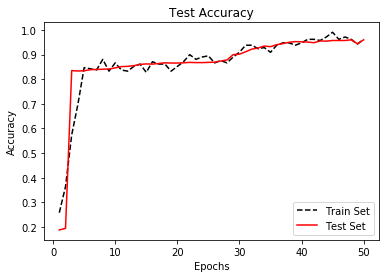

In [12]:
%matplotlib inline

# Plot loss over time
epoch_seq = np.arange(1, epochs+1)
plt.plot(epoch_seq, train_loss, 'k--', label='Train Set')
plt.plot(epoch_seq, test_loss, 'r-', label='Test Set')
plt.title('Softmax Loss')
plt.xlabel('Epochs')
plt.ylabel('Softmax Loss')
plt.legend(loc='upper left')
plt.show()

# Plot accuracy over time
plt.plot(epoch_seq, train_accuracy, 'k--', label='Train Set')
plt.plot(epoch_seq, test_accuracy, 'r-', label='Test Set')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()



In [13]:
sample_texts = ['Hi, please respond 1111 asap to claim your change to win now!',
                'Hey what are you doing for dinner tonight?',
                'New offer, show this text for 50% off of our inagural sale!',
                'Can you take the dog to the vet tomorrow?',
                'Congratulations! You have been randomly selected to receive account credit!']

In [14]:
clean_texts = [clean_text(text) for text in sample_texts]
print(clean_texts)



['hi please respond asap to claim your change to win now', 'hey what are you doing for dinner tonight', 'new offer show this text for off of our inagural sale', 'can you take the dog to the vet tomorrow', 'congratulations you have been randomly selected to receive account credit']


In [15]:
processed_texts = np.array(list(vocab_processor.transform(clean_texts)))
print(processed_texts)



[[ 93  99   0   0   1 114  13 524   1 178  21   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [121  52  20   3 151  12 332 208   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [ 92 376 483  39  69  12 203  15  86   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [ 28   3 104   5   0   1   5   0 143   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [701   3  17  98   0 420   1 318 301 738   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]]


In [16]:
# Remember to wrap the resulting logits in a softmax to get probabilities
eval_feed_dict = {x_data: processed_texts, dropout_keep_prob: 1.0}
model_results = sess.run(tf.nn.softmax(logits_out), feed_dict=eval_feed_dict)

print(model_results)



[[0.82748437 0.17251562]
 [0.01370636 0.9862937 ]
 [0.01374277 0.98625726]
 [0.01370667 0.9862933 ]
 [0.7867416  0.2132584 ]]


In [17]:
categories = ['spam', 'ham']

for ix, result in enumerate(model_results):
    prediction = categories[np.argmax(result)]
    
    print('Text: {}, \nPrediction: {}\n'.format(sample_texts[ix], prediction))



Text: Hi, please respond 1111 asap to claim your change to win now!, 
Prediction: spam

Text: Hey what are you doing for dinner tonight?, 
Prediction: ham

Text: New offer, show this text for 50% off of our inagural sale!, 
Prediction: ham

Text: Can you take the dog to the vet tomorrow?, 
Prediction: ham

Text: Congratulations! You have been randomly selected to receive account credit!, 
Prediction: spam

